## Inference of astrophysical parameters using 21cm power spectra.

Copy the zarr store to the local gpu node

In [1]:
%%time
!cp -r /data/p303146/Projects/Inference21cm/Astro_6/fixSeed/s21cm_Astro_6.zarr* /local/tmp/

CPU times: user 4.51 s, sys: 798 ms, total: 5.3 s
Wall time: 3min 17s


Importing dependencies

In [24]:
import numpy as np
np.random.seed(50);

from scipy import stats
import torch
torch.manual_seed(50);

import swyft as sl
import pytorch_lightning as pl
import pickle

import matplotlib.pyplot as plt
plt.rcParams["mathtext.fontset"] = "stix"
%config InlineBackend.figure_format = "svg"
%matplotlib inline

In [25]:
# Redshifts
reds = [24.359810, 20.219959, 17.111031, 14.457590, 12.456770,
        10.714930, 9.402521, 8.237142, 7.202319, 6.429094]

# Parameters: zeta, Tvir, Rmfp, Lx, E0, \alpha
labels = [r'$\zeta$', r'$T_{\rm vir}^{\rm min}$', r'$R_{\rm mfp}$',
          r'$L_X$', r'$E_0$', r'$\alpha_{X}$']

# True values of the parameters
vtrue = np.array([30, 4.69897, 15, 40.5, 500, 1])

# Priors
vmin = np.array([10, 4.2, 8, 39.5, 100, -0.5])
vmax = np.array([100, 5.4, 25, 41.5, 900, 2.5])

# k-modes
k_vals = np.linspace(0.1, 0.8, 8)

# Path for mock observation and noise
noisePath = "./../Training_Data/ska_low_noise.npy"
obsPath = "./../Training_Data/mockObs.pkl"

Thermal noise level

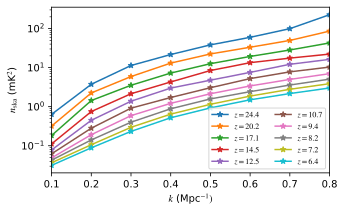

In [26]:
# Instrumental noise level from SKA low: sim using ps_eor
instNoise = np.load(noisePath)

fig, ax = plt.subplots(figsize=(5, 3))
for i in range(len(reds)):
    ax.plot(k_vals, instNoise[i], "*-", label=r"$z = %.1f$"%reds[i])
    ax.set_yscale("log")
    ax.set_xlim(k_vals[0], k_vals[-1])
    ax.legend(ncol=2, fontsize=8)
    ax.set_xlabel(r"$k$ (Mpc$^{-1})$")
    ax.set_ylabel(r"$n_{\rm ska}$ (mK$^2$)")

Mock Observation

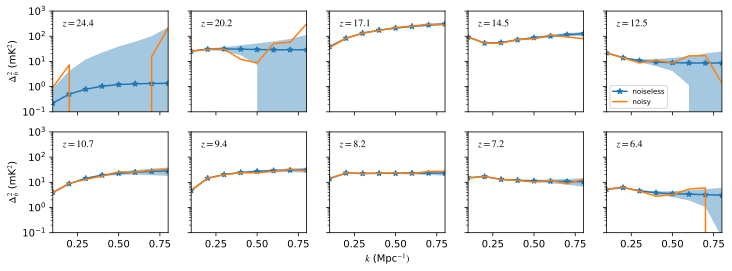

In [27]:
with open(obsPath, 'rb') as f:
    obs0 = pickle.load(f)
    
fig, ax = plt.subplots(2, 5, figsize=(12, 4), sharex=True, sharey=True)
for i, ax in enumerate(fig.axes):
    sigma = np.sqrt(instNoise[i]**2. + (obs0['pk_sv_z%.1f'%reds[i]].numpy())**2.)
    ax.plot(k_vals, obs0['pk_mu_z%.1f'%reds[i]], "*-", label="noiseless")
    ax.fill_between(k_vals, obs0['pk_mu_z%.1f'%reds[i]] - sigma,
                   obs0['pk_mu_z%.1f'%reds[i]] + sigma, alpha=0.4)
    ax.plot(k_vals, obs0['pk_z%.1f'%reds[i]], label="noisy")
    ax.set_ylim(1e-1, 1e3)
    ax.set_xlim(k_vals[0], k_vals[-1])
    ax.set_yscale("log")
    if i == 4: ax.legend(loc="lower left", fontsize=7)
    if i == 7: ax.set_xlabel(r"$k$ (Mpc$^{-1})$")
    if i == 0 or i == 5: ax.set_ylabel(r"$\Delta_{b}^2$ (mK$^2$)")
    ax.text(0.16, 2.5*1e2, r"$z=%.1f$"%reds[i], fontsize=10)

Noise model (Sample variance + Thermal noise)

In [28]:
# Use it as a hook: takes into account the instrumental noise and sample variance
def noise(out):
    for i in range(len(reds)):
        mu = out['pk_mu_z%.1f'%reds[i]]
        sv = out['pk_sv_z%.1f'%reds[i]]
        
        # Total noise including the intrumental noise and sample variance
        total_noise_val = np.sqrt(instNoise[i]**2. + sv**2.)
        n = np.float32(np.random.randn(*total_noise_val.shape))*total_noise_val
        
        out['pk_z%.1f'%reds[i]] = mu + n
    return out

Store and data loaders

In [29]:
zs = sl.ZarrStore("/local/tmp/s21cm_Astro_6.zarr")
data_loader_train = zs.get_dataloader(num_workers=12, batch_size=64, idx_range=[0, 16_000],
                                      on_after_load_sample=noise)
data_loader_val = zs.get_dataloader(num_workers=12, batch_size=64, idx_range=[16_000, 18_000],
                                    on_after_load_sample=noise)
data_loader_test = zs.get_dataloader(num_workers=12, batch_size=64, idx_range=[18_000, 20_000],
                                     on_after_load_sample=noise)

Trainer, logger and callbacks

In [30]:
logger = pl.loggers.TensorBoardLogger("/data/p303146/lightning_logs", name = "post_1D_2D")
model_checkpoint = pl.callbacks.ModelCheckpoint(monitor = 'val_loss', save_top_k=1)
callbacks = [
    pl.callbacks.LearningRateMonitor(),
    pl.callbacks.EarlyStopping("val_loss", patience=5),
    model_checkpoint
]

trainer = sl.SwyftTrainer(accelerator='gpu', gpus=1, max_epochs=100, logger=logger,
                          callbacks=callbacks, precision=32)

/data/p303146/.envs/newLight/lib/python3.9/site-packages/pytorch_lightning-1.8.0.post1-py3.9.egg/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
/data/p303146/.envs/newLight/lib/python3.9/site-packages/pytorch_lightning-1.8.0.post1-py3.9.egg/lightning_lite/plugins/environments/slurm.py:169: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/p303146/.envs/newLight/lib/python3.9/site-pack ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/usr/bin/srun


Network: Ratio estimator

In [31]:
class Network(sl.SwyftModule):
    def __init__(self):
        super().__init__()
        
        self.n_features = 64
        marginals = self.get_marginals(n_params=len(vtrue))
        self.l = torch.nn.Linear(80, self.n_features)
        self.logratios1 = sl.LogRatioEstimator_1dim(num_features=self.n_features,
                                                    num_params=len(vtrue),
                                                    hidden_features=256,
                                                    num_blocks=3,
                                                    dropout=0.2,
                                                    varnames='z')
        self.logratios2 = sl.LogRatioEstimator_Ndim(num_features=self.n_features,
                                                    marginals=marginals,
                                                    hidden_features=256,
                                                    num_blocks=3,
                                                    dropout=0.2,
                                                    varnames ='z')

    @staticmethod
    def get_marginals(n_params):
        marginals = []
        for i in range(n_params):
            for j in range(n_params):
                if j>i: marginals.append((i, j))
        return tuple(marginals)
        
    def forward(self, A, B):
        x = torch.cat([A['pk_z%.1f'%zi] for zi in reds], axis=1)
        x = self.l(x)
        z = B['z']
        ratios_1 = self.logratios1(x, z)
        ratios_2 = self.logratios2(x, z)
        return ratios_1, ratios_2

In [32]:
network = Network()

Training the network

In [33]:
if os.path.exists("./01_output/trainedLogRatios.pt"):
    network.load_state_dict(torch.load("./01_output/trainedLogRatios.pt"))
else:
    trainer.fit(network, data_loader_train, data_loader_val)

/data/p303146/.envs/newLight/lib/python3.9/site-packages/pytorch_lightning-1.8.0.post1-py3.9.egg/lightning_lite/plugins/environments/slurm.py:169: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/p303146/.envs/newLight/lib/python3.9/site-pack ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                   | Params
------------------------------------------------------
0 | l          | Linear                 | 5.2 K 
1 | logratios1 | LogRatioEstimator_1dim | 2.5 M 
2 | logratios2 | LogRatioEstimator_Ndim | 6.2 M 
------------------------------------------------------
8.7 M     Trainable params
0         Non-trainable params
8.7 M     Total params
34.894    Total estimated model params size (MB)


/usr/bin/srun


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Save the trained network

In [34]:
torch.save(network.state_dict(), "./01_output/trainedLogRatios.pt")

Network performance on the test dataset

In [35]:
trainer.test(network, data_loader_test)

/data/p303146/.envs/newLight/lib/python3.9/site-packages/pytorch_lightning-1.8.0.post1-py3.9.egg/lightning_lite/plugins/environments/slurm.py:169: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/p303146/.envs/newLight/lib/python3.9/site-pack ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/usr/bin/srun


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           -16.593639373779297
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': -16.593639373779297}]

Sampling from prior

In [36]:
def uv(u):
    return u * (vmax - vmin) + vmin

prior_samples = sl.Samples(z = uv(np.random.rand(200_000, 6)).astype('f'))

Predictions

In [37]:
pred = trainer.infer(network, sl.Sample(obs0), prior_samples)

/data/p303146/.envs/newLight/lib/python3.9/site-packages/pytorch_lightning-1.8.0.post1-py3.9.egg/lightning_lite/plugins/environments/slurm.py:169: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/p303146/.envs/newLight/lib/python3.9/site-pack ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/usr/bin/srun


Predicting: 250it [00:00, ?it/s]

Corner plot

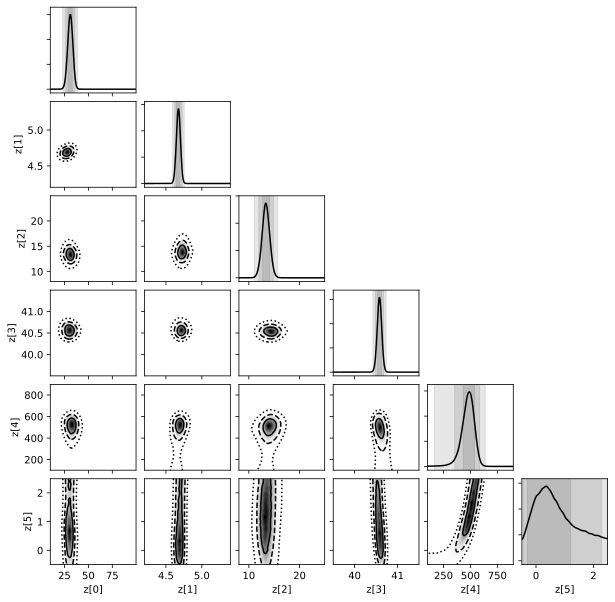

In [38]:
sl.corner(pred, ('z[0]', 'z[1]', 'z[2]', 'z[3]', 'z[4]', 'z[5]'), bins=200,
          smooth=3, truth=[30, 4.7, 15, 40.5, 500, 1]);

In [39]:
open_file = open("./01_output/logRatioSamples.pkl", "wb")
pickle.dump(pred, open_file)
open_file.close()

---
### Coverage Illustration

In [40]:
prior_samples = sl.Samples(z = uv(np.random.rand(10_000, 6)).astype('f'))

In [41]:
coverage_samples = trainer.test_coverage(network, noise(zs[-500:]), prior_samples)

/data/p303146/.envs/newLight/lib/python3.9/site-packages/pytorch_lightning-1.8.0.post1-py3.9.egg/lightning_lite/plugins/environments/slurm.py:169: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/p303146/.envs/newLight/lib/python3.9/site-pack ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/usr/bin/srun


Predicting: 250it [00:00, ?it/s]

/data/p303146/.envs/newLight/lib/python3.9/site-packages/pytorch_lightning-1.8.0.post1-py3.9.egg/lightning_lite/plugins/environments/slurm.py:169: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/p303146/.envs/newLight/lib/python3.9/site-pack ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/usr/bin/srun


Predicting: 250it [00:00, ?it/s]

In [42]:
from matplotlib.axes import Axes
from typing import Optional, Sequence, Tuple, Union

def get_alpha(z_score: Union[float, np.ndarray]) -> np.ndarray:
    """Recover the alpha (significance level) given by `alpha = 2 * (1 - normal_cdf(z_score))`.
    Args:
        z_score: z_score aka `z`
    Returns:
        alpha: significance level
    """
    return 2 * (1 - stats.norm.cdf(z_score))

def plot_empirical_z_score(
    axes: Axes,
    nominal_z_scores: np.ndarray,
    z_mean: np.ndarray,
    z_interval: np.ndarray,
    mean_color: str = "black",
    interval_color: str = "0.8",
    diagonal_color: str = "darkgreen",
    sigma_color: str = "red",
    xlim: Optional[Tuple[float, float]] = None,
    ylim: Optional[Tuple[float, float]] = None,
    xlabel: Optional[str] = r"Empirical coverage [$z_p$]",
    ylabel: Optional[str] = r"Nominal credibility [$z_p$]",
    diagonal_text: bool = False,
    fsize: int = 12,
    lw_horizonal=1,
    lw_vertical=1,
    lw_empirical=1,
    lw_diagonal=1
) -> Axes:
    """target a particular matplotlib Axes and produce an empirical coverage test plot with Jeffrey's interval
    Args:
        axes: matplotlib axes
        nominal_z_scores: sorted array of nominal z-scores
        z_mean: empirical mean of z-score estimate using a binominal distribution
        z_interval: jeffrey's interval of z-score estimate
        mean_color: color of the mean line.
        interval_color: color of the interval, floats are grey.
        diagonal_color: color of the diagonal, nominal z-score.
        sigma_color: color of the vertical and horizontal sigma lines.
        xlim: force xlim
        ylim: force ylim
        xlabel: set xlabel
        ylabel: set ylabel
        diagonal_text: turns on semantic description of above / below diagonal
    Returns:
        the matplotlib axes given
    """
    lower = z_interval[:, 0]
    upper = z_interval[:, 1]
    assert np.all(lower <= upper), "the lower interval must be <= the upper interval."
    upper = np.where(upper == np.inf, 100.0, upper)

    # empirical lines & interval
    axes.plot(nominal_z_scores, z_mean, color=mean_color, lw=lw_empirical)
    axes.fill_between(nominal_z_scores, lower, upper, color=interval_color)

    # diagonal line
    max_z_score = np.max(nominal_z_scores)
    axes.plot([0, max_z_score], [0, max_z_score], "--", color=diagonal_color, lw=lw_diagonal)

    # horizontal and vertical lines, vertical are the "truth", horizontal are empirical
    for i_sigma in range(1, int(max_z_score) + 1):
        empirical_i_sigma = np.interp(i_sigma, nominal_z_scores, z_mean)
        if empirical_i_sigma != np.inf:  # when the vertical line intersects z_mean
            # Horizontal line
            axes.plot(
                [0, i_sigma],
                [empirical_i_sigma, empirical_i_sigma],
                ":",
                color=sigma_color,
                lw=lw_horizonal
            )
            # horizontal text
            c = 1 - get_alpha(empirical_i_sigma)
            axes.text(0.15, empirical_i_sigma + 0.05, (r"$%.2f$" % (c * 100)) + "$\%$", fontsize=fsize)
            # vertical line
            axes.plot(
                [i_sigma, i_sigma], [0, empirical_i_sigma], ":", color=sigma_color, lw=lw_vertical
            )
            # vertical text
            c = 1 - get_alpha(i_sigma)
            axes.text(i_sigma, 0.15, (r"$%.2f$" % (c * 100)) + "$\%$", rotation=-90, fontsize=fsize)
        else:  # when the vertical line fails to intersect z_mean
            pass

    # set labels
    axes.set_ylabel(xlabel)
    axes.set_xlabel(ylabel)

    # Add the semantic meaning of being above / below diagonal
    if diagonal_text:
        raise NotImplementedError("must add rotation description")

    # set limits
    if xlim is None:
        axes.set_xlim([0, max_z_score])
    else:
        axes.set_xlim(xlim)

    if ylim is None:
        axes.set_ylim([0, max_z_score + np.round(0.15 * max_z_score, 1)])
    else:
        axes.set_ylim(ylim)
    return axes


In [43]:
import seaborn as sns
cmap = sns.cubehelix_palette(start=0, light=0.98, dark=0.4, as_cmap=True)

def coveragePlot():
    fig, ax = plt.subplots(6, 6, figsize=(10, 10), sharex=True, sharey=True) #, constrained_layout=True)
    labels = [r'$\zeta$', r'$\log_{10}(T_{\rm vir}^{\rm min})$', r'$R_{\rm mfp}$',
              r'$\log_{10}(L_{X})$', r'$E_0$', r'$\alpha_X$']
    cn = 0
    lower_lim = 1
    for i in range(0, 5):     
        for j in range(lower_lim, 6):         
            cov = sl.estimate_coverage(coverage_samples, coverage_samples[1].parnames[cn].tolist())
            plot_empirical_z_score(ax[j, i], cov[:, 0], cov[:, 1], cov[:, 2:], xlabel="", ylabel="", mean_color=cmap(0.999),
                               interval_color=cmap(0.2), sigma_color="grey", diagonal_color="g", fsize=6,
                               lw_horizonal=0.5, lw_vertical=0.5, lw_diagonal=0.5)
            cn += 1     
        lower_lim+=1      

    for i in range(6):
        for j in range(6):
            ax[i, j].tick_params(axis='both', which='major', labelsize=8, length=3)
            ax[i, j].tick_params(axis='both', which='minor', labelsize=8, length=2)
            if j > i:
                ax[i, j].set_axis_off()
            ax[i, j].set_xticks([0, 1, 2, 3])
            if i == j:
                cov = sl.estimate_coverage(coverage_samples, "z[%d]"%i)
                plot_empirical_z_score(ax[i, j], cov[:, 0], cov[:, 1], cov[:, 2:], xlabel="", ylabel="", mean_color=cmap(0.999),
                                       interval_color=cmap(0.2), sigma_color="grey", diagonal_color="g", fsize=6,
                                       lw_horizonal=0.5, lw_vertical=0.5, lw_diagonal=0.5)

    for i in range(len(labels)):
        ax[i, 0].set_ylabel(labels[i], fontsize=10)
        ax[-1, i].set_xlabel(labels[i], fontsize=10)
        ax[i, 0].get_yaxis().set_label_coords(-0.25, 0.5)
        ax[-1, i].get_xaxis().set_label_coords(0.5, -0.25)
    ax[0, 0].set_ylabel("")
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    fig.align_xlabels()
    fig.align_ylabels()

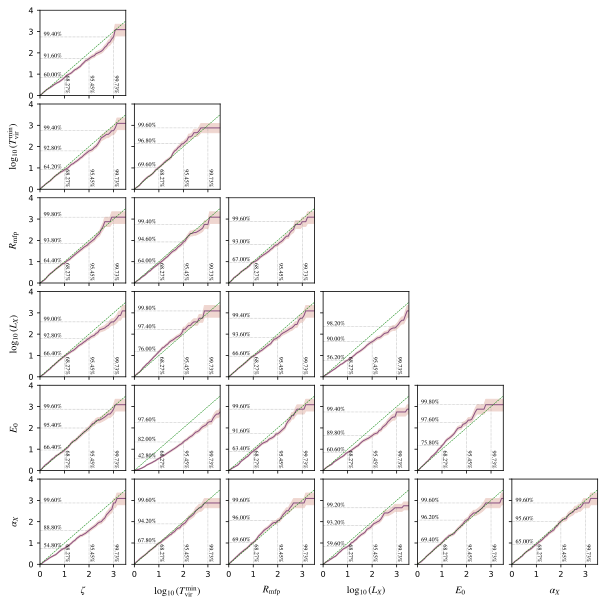

In [44]:
coveragePlot()

In [45]:
open_file = open("./01_output/coverageData.pkl", "wb")
pickle.dump(coverage_samples, open_file)
open_file.close()